# Notebook de treinamento de redes convolucionais com os dados classificados por especialistas

Neste notebook treinamos diversas arquiteturas de redes convolucionais partindo dos pesos da ImageNet. Para este notebook, usamos apenas os dados anotados por especialistas e avaliamos as redes no conjunto de validação.

# Base de dados e importações

In [ ]:
!gdown --id 1AXsjBK_TAAWgiWKq-68xuc91btNcLRcW --output dados.zip
!unzip dados.zip
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

Downloading...
From: https://drive.google.com/uc?id=1AXsjBK_TAAWgiWKq-68xuc91btNcLRcW
To: /content/dados.zip
35.2MB [00:00, 36.4MB/s]
Archive:  dados.zip
   creating: content/audios_MFCC_especialistas/
  inflating: content/audios_MFCC_especialistas/350e8396-e67e-491a-89dd-666702548d63.jpg  
  inflating: content/audios_MFCC_especialistas/811d96a7-e63f-4a8e-afc8-d8cef7bec7aa.jpg  
  inflating: content/audios_MFCC_especialistas/b408553b-befa-4a28-ab99-a10bb23384fc.jpg  
  inflating: content/audios_MFCC_especialistas/c91f755a-e37e-4106-a90a-bb0672fdfd24.jpg  
  inflating: content/audios_MFCC_especialistas/c35098aa-e1d0-41f2-94b3-38e98f389c9f.jpg  
  inflating: content/audios_MFCC_especialistas/bb84b88b-acd0-4975-8d43-0d0ebbf071f3.jpg  
  inflating: content/audios_MFCC_especialistas/43df4f16-fb75-43bb-a866-5231a9243e21.jpg  
  inflating: content/audios_MFCC_especialistas/e1259ecf-0b60-4106-9852-61c945065ab1.jpg  
  inflating: content/audios_MFCC_especialistas/aa78817e-f5e3-470b-b516-6006c59

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.jpg'
val['uuid'] = val['uuid'] + '.jpg'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.3982300884955752
*   symptomatic -  represenatado pelo 1 - ficou com o peso 1.0 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 1.5906040268456376

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.3982300884955752, 1: 1.0, 2: 1.5906040268456376}

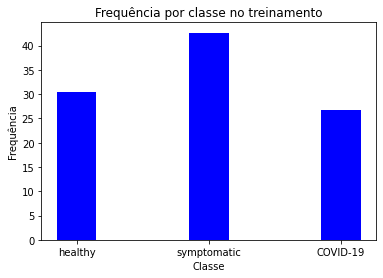

In [ ]:
plt.bar(0, len(train.values[train.classInt.values == 0])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(1, len(train.values[train.classInt.values == 1])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(2, len(train.values[train.classInt.values == 2])/len(train.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no treinamento')
plt.savefig('Treinamento-especialista.png')

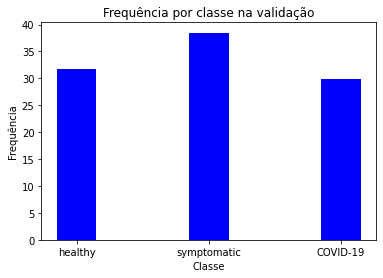

In [ ]:
plt.bar(0, len(val.values[val.classInt.values == 0])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(1, len(val.values[val.classInt.values == 1])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(2, len(val.values[val.classInt.values == 2])/len(val.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe na validação')
plt.savefig('Validacao.png')

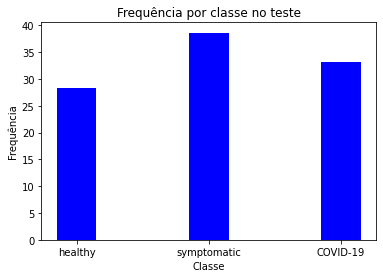

In [ ]:
teste = pd.read_csv('/content/CSV/test.csv')
teste['classInt'] = teste['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
plt.bar(0, len(teste.values[teste.classInt.values == 0])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(1, len(teste.values[teste.classInt.values == 1])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(2, len(teste.values[teste.classInt.values == 2])/len(teste.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no teste')
plt.savefig('Teste.png')

# Função para treinamento de modelos

Como foi analisado que a execução de uma época da rede dura poucos segundos iremos testar a base com esse pré-processamento em 21 redes diferentes da imagenet para ver qual obteve a melhor acurácia tornando-a por fim o nosso baseline inicial. As redes a serem analisadas são listadas abaixo:

ResNet50
ResNet101	
ResNet152	
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5	
EfficientNetB6	
EfficientNetB7	
MobileNet	
MobileNetV2	
DenseNet121	
DenseNet169	
DenseNet201	
InceptionV3	
InceptionResNetV2	
Xception	
VGG16	
VGG19	

In [ ]:
def cria_e_treina_rede(model_name, train_df, val_df, batch_size=32, callbacks=[], image_size=(256, 256), pooling='avg', loss='categorical_crossentropy', epochs=500, class_weights=class_weights, trainable=True):

  if model_name == 'resnet50' or model_name == 'resnet101' or model_name == 'resnet152':
    preprocessing_function = tf.keras.applications.resnet.preprocess_input
  elif model_name == 'efficientnetb0' or model_name == 'efficientnetb1' or model_name == 'efficientnetb2' or model_name == 'efficientnetb3' or model_name == 'efficientnetb4' or model_name == 'efficientnetb5'  or model_name == 'efficientnetb6' or model_name == 'efficientnetb7':
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
  elif model_name == 'mobilenet':
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input
  elif model_name == 'mobilenetv2':
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
  elif model_name == 'densenet121' or model_name == 'densenet169' or model_name == 'densenet201':
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
  elif model_name == 'inceptionv3':
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
  elif model_name == 'inceptionresnetv2':
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input
  elif model_name == 'xception':
    preprocessing_function = tf.keras.applications.xception.preprocess_input
  elif model_name == 'vgg16':
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
  elif model_name == 'vgg19':
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing_function,
  )

  train_generator = datagen.flow_from_dataframe(
    train_df, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42, color_mode='rgb')

  val_generator = datagen.flow_from_dataframe(
    val_df, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=False, seed=42, color_mode='rgb')
  
  if model_name == 'resnet50':
    pre_trained = tf.keras.applications.ResNet50(include_top=False, pooling=pooling)
  elif model_name == 'resnet101':
    pre_trained = tf.keras.applications.ResNet101(include_top=False, pooling=pooling)
  elif model_name == 'resnet152':
    pre_trained = tf.keras.applications.ResNet152(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb0':
    pre_trained = tf.keras.applications.EfficientNetB0(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb1':
    pre_trained = tf.keras.applications.EfficientNetB1(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb2':
    pre_trained = tf.keras.applications.EfficientNetB2(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb3':
    pre_trained = tf.keras.applications.EfficientNetB3(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb4':
    pre_trained = tf.keras.applications.EfficientNetB4(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb5':
    pre_trained = tf.keras.applications.EfficientNetB5(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb6':
    pre_trained = tf.keras.applications.EfficientNetB6(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb7':
    pre_trained = tf.keras.applications.EfficientNetB7(include_top=False, pooling=pooling)
  elif model_name == 'mobilenet':
    pre_trained = tf.keras.applications.MobileNet(include_top=False, pooling=pooling)
  elif model_name == 'mobilenetv2':
    pre_trained = tf.keras.applications.MobileNetV2(include_top=False, pooling=pooling)
  elif model_name == 'densenet121':
    pre_trained = tf.keras.applications.DenseNet121(include_top=False, pooling=pooling)
  elif model_name == 'densenet169':
    pre_trained = tf.keras.applications.DenseNet169(include_top=False, pooling=pooling)
  elif model_name == 'densenet201':
    pre_trained = tf.keras.applications.DenseNet201(include_top=False, pooling=pooling)
  elif model_name == 'inceptionv3':
    pre_trained = tf.keras.applications.InceptionV3(include_top=False, pooling=pooling)
  elif model_name == 'inceptionresnetv2':
    pre_trained = tf.keras.applications.InceptionResNetV2(include_top=False, pooling=pooling)
  elif model_name == 'xception':
    pre_trained = tf.keras.applications.Xception(include_top=False, pooling=pooling)
  elif model_name == 'vgg16':
    pre_trained = tf.keras.applications.VGG16(include_top=False, pooling=pooling)
  elif model_name == 'vgg19':
    pre_trained = tf.keras.applications.VGG19(include_top=False, pooling=pooling)

  for layer in pre_trained.layers:
    layer.treinable = trainable

  model = tf.keras.models.Sequential([
   pre_trained,
   tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.summary()

  optimizer = tf.keras.optimizers.Adam(0.000001)

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))
  if 'checkpoint' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('/content/' + model_name + '.hdf5', save_best_only=True, verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(model_name + ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  predict_val = model.predict(val_generator, verbose=1)
  y_true = []

  i = 0
  for batch, label in val_generator:
    i += batch.shape[0]
    for l in np.argmax(label, axis=1):
      y_true.append(l)
    if i == len(val_df): break

  y_true = np.array(y_true)

  print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

  cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
  cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cm) / 3
  print('Acuracia balanceada na validacao:', balanced_acc)

  return model

# Modelos

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
35/35 [==============================] - 28s 214ms/step - loss: 1.5678 - acc: 0.3537 - val_loss: 1.7506 - val_acc: 0.3849
Epoch 2/500
35/35 [========================

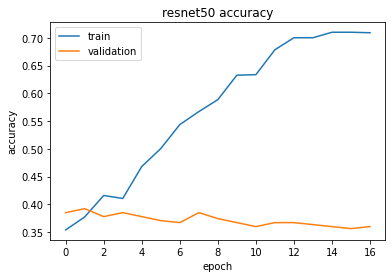

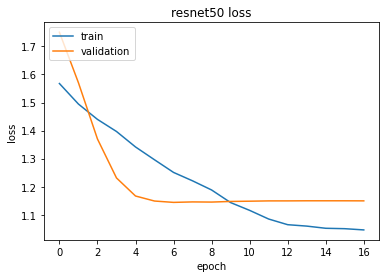

9/9 [==============================] - 1s 73ms/step
[[14 49 25]
 [17 61 29]
 [13 43 27]]
Acuracia balanceada na validacao: 0.3514951906180371


In [ ]:
cria_e_treina_rede('resnet50', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
171450368/171446536 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 42,664,323
Trainable params: 42,558,979
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 20s 298ms/step - loss: 1.8979 - acc: 0.2718 - val_loss: 1.5710 - val_acc: 0.2914
Epoch 2/500
35/35 [==============================] - 9s 246ms/step - loss: 1.7172 - acc: 0.2844 - val_loss: 1.4611 - val_acc: 0.2914
Epoch 3/500
35/35 [========================

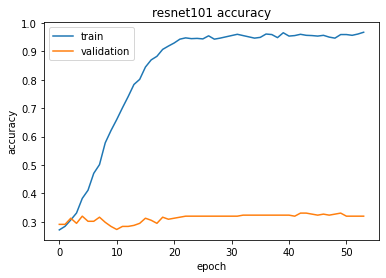

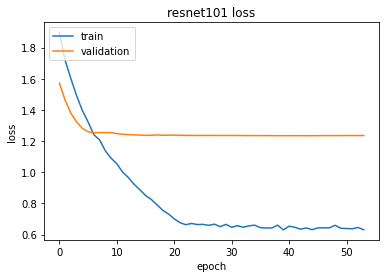

9/9 [==============================] - 2s 77ms/step
[[19 35 34]
 [22 39 46]
 [22 27 34]]
Acuracia balanceada na validacao: 0.3300112088114565


In [ ]:
cria_e_treina_rede('resnet101', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
234700800/234698864 [==============================] - 8s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 58,377,091
Trainable params: 58,225,667
Non-trainable params: 151,424
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 30s 423ms/step - loss: 1.7408 - acc: 0.2979 - val_loss: 1.9668 - val_acc: 0.3129
Epoch 2/500
35/35 [==============================] - 12s 349ms/step - loss: 1.6171 - acc: 0.3159 - val_loss: 1.7689 - val_acc: 0.3237
Epoch 3/500
35/35 [=======================

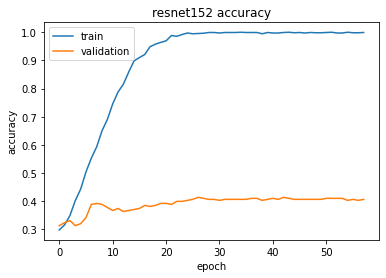

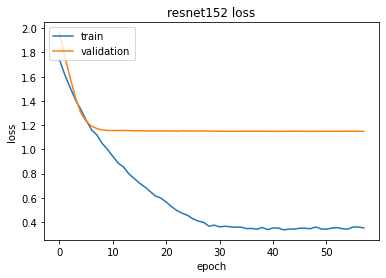

9/9 [==============================] - 3s 98ms/step
[[38 26 24]
 [35 44 28]
 [30 22 31]]
Acuracia balanceada na validacao: 0.40550903699760815


In [ ]:
cria_e_treina_rede('resnet152', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 17s 267ms/step - loss: 1.4852 - acc: 0.3942 - val_loss: 1.1278 - val_acc: 0.3129
Epoch 2/500
35/35 [==============================] - 7s 207ms/step - loss: 1.4748 - acc: 0.4158 - val_loss: 1.1338 - val_acc: 0.3058
Epoch 3/500
35/35 [=============================

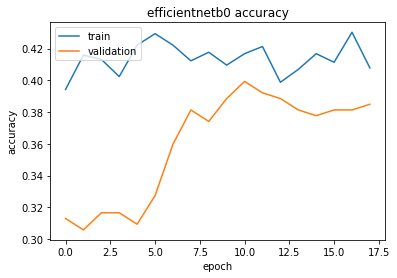

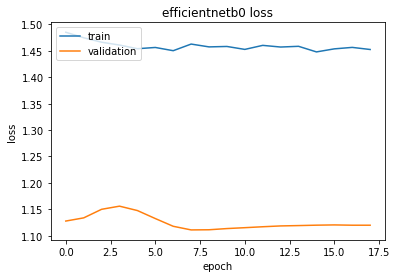

9/9 [==============================] - 2s 58ms/step
[[20 58 10]
 [20 82  5]
 [13 66  4]]
Acuracia balanceada na validacao: 0.34727354618132683


In [ ]:
cria_e_treina_rede('efficientnetb0', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
27025408/27018416 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3843      
Total params: 6,579,082
Trainable params: 6,517,027
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 23s 352ms/step - loss: 1.4439 - acc: 0.3573 - val_loss: 1.2328 - val_acc: 0.3813
Epoch 2/500
35/35 [==============================] - 10s 297ms/step - loss: 1.4499 - acc: 0.3429 - val_loss: 1.1753 - val_acc: 0.3921
Epoch 3/500
35/35 [============================

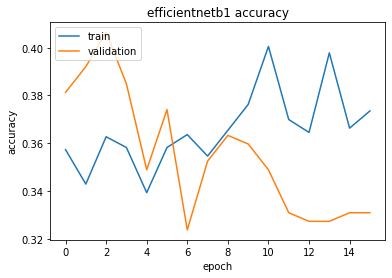

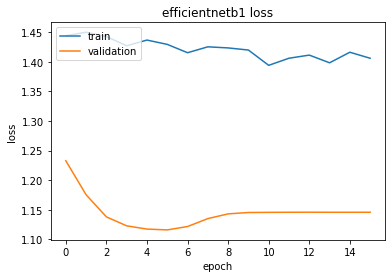

9/9 [==============================] - 2s 58ms/step
[[23 55 10]
 [23 62 22]
 [13 51 19]]
Acuracia balanceada na validacao: 0.3565728504502291


In [ ]:
cria_e_treina_rede('efficientnetb1', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
31793152/31790344 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 4227      
Total params: 7,772,796
Trainable params: 7,705,221
Non-trainable params: 67,575
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 24s 378ms/step - loss: 1.4569 - acc: 0.3573 - val_loss: 1.1572 - val_acc: 0.3129
Epoch 2/500
35/35 [==============================] - 11s 302ms/step - loss: 1.4295 - acc: 0.3645 - val_loss: 1.1658 - val_acc: 0.3058
Epoch 3/500
35/35 [============================

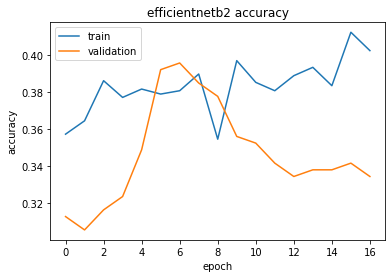

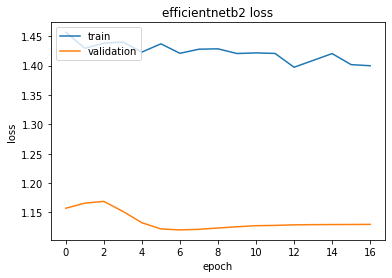

9/9 [==============================] - 2s 59ms/step
[[11 48 29]
 [12 70 25]
 [20 34 29]]
Acuracia balanceada na validacao: 0.3762010659460271


In [ ]:
cria_e_treina_rede('efficientnetb2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
43941888/43941136 [==============================] - 2s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 4611      
Total params: 10,788,146
Trainable params: 10,700,843
Non-trainable params: 87,303
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 28s 453ms/step - loss: 1.4488 - acc: 0.3753 - val_loss: 1.1482 - val_acc: 0.3885
Epoch 2/500
35/35 [==============================] - 13s 367ms/step - loss: 1.4498 - acc: 0.3699 - val_loss: 1.1152 - val_acc: 0.3849
Epoch 3/500
35/35 [==========================

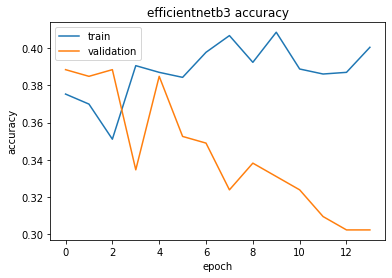

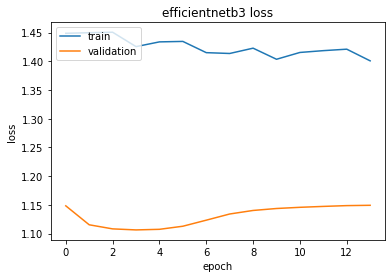

9/9 [==============================] - 2s 60ms/step
[[18 48 22]
 [26 58 23]
 [15 51 17]]
Acuracia balanceada na validacao: 0.3171402688067478


In [ ]:
cria_e_treina_rede('efficientnetb3', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
71688192/71686520 [==============================] - 3s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 5379      
Total params: 17,679,202
Trainable params: 17,553,995
Non-trainable params: 125,207
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 34s 531ms/step - loss: 1.4433 - acc: 0.3168 - val_loss: 1.0996 - val_acc: 0.4065
Epoch 2/500
35/35 [==============================] - 15s 438ms/step - loss: 1.4429 - acc: 0.3060 - val_loss: 1.1066 - val_acc: 0.3453
Epoch 3/500
35/35 [=========================

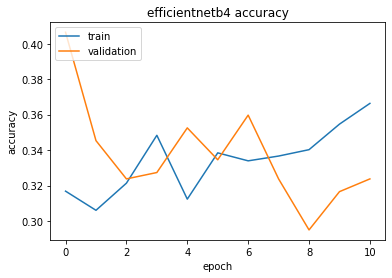

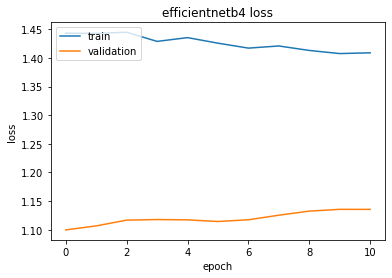

9/9 [==============================] - 3s 65ms/step
[[32 42 14]
 [23 64 20]
 [23 43 17]]
Acuracia balanceada na validacao: 0.3888621606220976


In [ ]:
cria_e_treina_rede('efficientnetb4', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
115269632/115263384 [==============================] - 3s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 6147      
Total params: 28,519,674
Trainable params: 28,346,931
Non-trainable params: 172,743
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 47s 396ms/step - loss: 1.4303 - acc: 0.3537 - val_loss: 1.1261 - val_acc: 0.3417
Epoch 2/500
70/70 [==============================] - 24s 338ms/step - loss: 1.4276 - acc: 0.3681 - val_loss: 1.1294 - val_acc: 0.2986
Epoch 3/500
70/70 [=======================

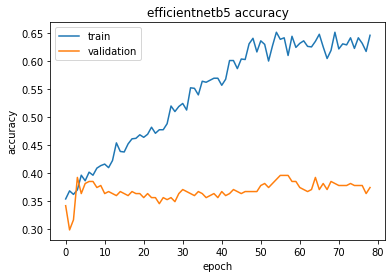

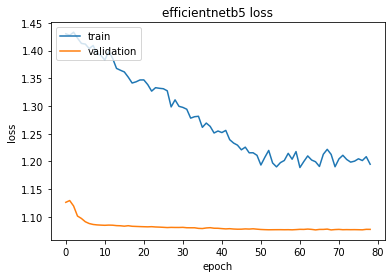

18/18 [==============================] - 3s 48ms/step
[[37 32 19]
 [35 40 32]
 [30 23 30]]
Acuracia balanceada na validacao: 0.38524403476267005


In [ ]:
cria_e_treina_rede('efficientnetb5', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
165240832/165234480 [==============================] - 5s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 2304)              40960143  
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 6915      
Total params: 40,967,058
Trainable params: 40,742,619
Non-trainable params: 224,439
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 56s 475ms/step - loss: 1.4209 - acc: 0.3393 - val_loss: 1.1051 - val_acc: 0.3417
Epoch 2/500
70/70 [==============================] - 29s 413ms/step - loss: 1.4263 - acc: 0.3456 - val_loss: 1.1100 - val_acc: 0.3597
Epoch 3/500
70/70 [=======================

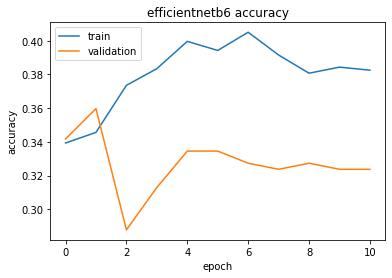

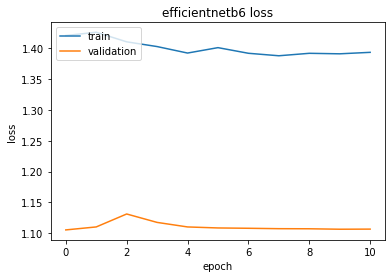

18/18 [==============================] - 4s 62ms/step
[[ 4 50 34]
 [ 4 53 50]
 [ 4 41 38]]
Acuracia balanceada na validacao: 0.3328709911864962


In [ ]:
cria_e_treina_rede('efficientnetb6', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
258080768/258076736 [==============================] - 8s 0us/step
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 2560)              64097687  
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 7683      
Total params: 64,105,370
Trainable params: 63,794,643
Non-trainable params: 310,727
_________________________________________________________________
Epoch 1/500
139/139 [==============================] - 77s 364ms/step - loss: 1.4199 - acc: 0.3753 - val_loss: 1.1248 - val_acc: 0.3273
Epoch 2/500
139/139 [==============================] - 44s 314ms/step - loss: 1.4129 - acc: 0.3798 - val_loss: 1.0842 - val_acc: 0.4101
Epoch 3/500
139/139 [================

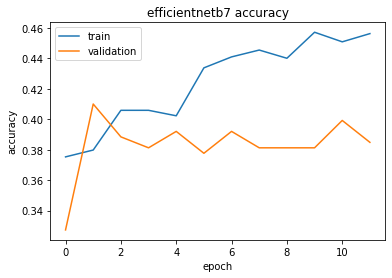

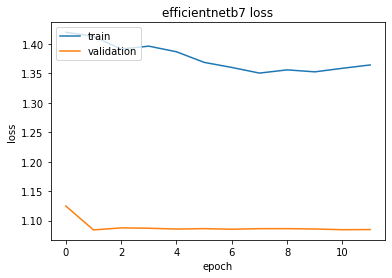

35/35 [==============================] - 6s 48ms/step
[[33 20 35]
 [41 40 26]
 [22 20 41]]
Acuracia balanceada na validacao: 0.41426922643846414


In [ ]:
cria_e_treina_rede('efficientnetb7', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=8)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 9s 182ms/step - loss: 1.9359 - acc: 0.3717 - val_loss: 1.5798 - val_acc: 0.3381
Epoch 2/500
35/35 [==============================] - 5s 155ms/step - loss: 1.9021 - acc: 0.3672 - val_loss: 1.4497 - val_acc: 0.3417
Epoch 3/500
35/35 [=============================

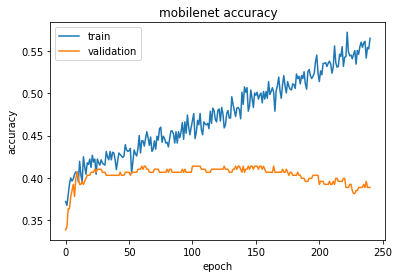

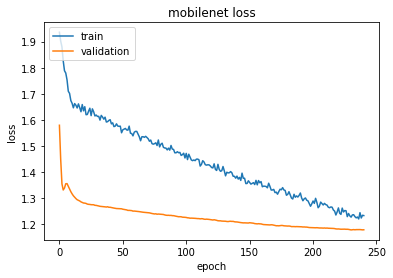

9/9 [==============================] - 1s 57ms/step
[[19 47 22]
 [15 56 36]
 [11 40 32]]
Acuracia balanceada na validacao: 0.37493858185503265


In [ ]:
cria_e_treina_rede('mobilenet', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 10s 190ms/step - loss: 1.6008 - acc: 0.2844 - val_loss: 1.1765 - val_acc: 0.3597
Epoch 2/500
35/35 [==============================] - 6s 167ms/step - loss: 1.5656 - acc: 0.3042 - val_loss: 1.1710 - val_acc: 0.3777
Epoch 3/500
35/35 [==============================

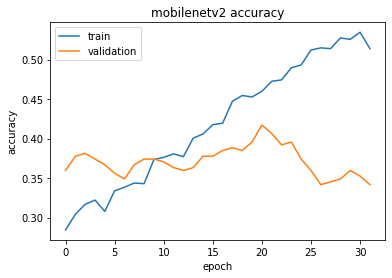

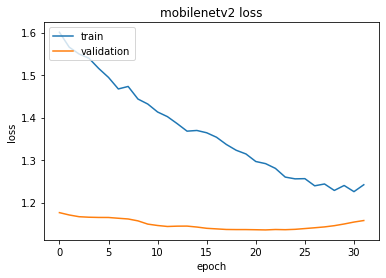

9/9 [==============================] - 1s 58ms/step
[[13 50 25]
 [ 8 73 26]
 [ 9 47 27]]
Acuracia balanceada na validacao: 0.3850904894002518


In [ ]:
cria_e_treina_rede('mobilenetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
29089792/29084464 [==============================] - 1s 0us/step
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 20s 280ms/step - loss: 1.6997 - acc: 0.3042 - val_loss: 1.1667 - val_acc: 0.3705
Epoch 2/500
35/35 [==============================] - 6s 167ms/step - loss: 1.6477 - acc: 0.3141 - val_loss: 1.1931 - val_acc: 0.3094
Epoch 3/500
35/35 [============================

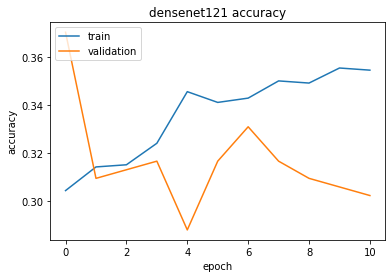

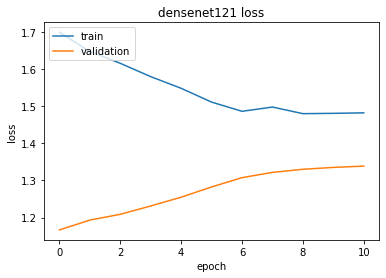

9/9 [==============================] - 2s 71ms/step
[[12 72  4]
 [11 88  8]
 [10 70  3]]
Acuracia balanceada na validacao: 0.3316460404063151


In [ ]:
cria_e_treina_rede('densenet121', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
51879936/51877672 [==============================] - 2s 0us/step
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 12,489,475
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 24s 300ms/step - loss: 1.7776 - acc: 0.2709 - val_loss: 1.5837 - val_acc: 0.3165
Epoch 2/500
35/35 [==============================] - 7s 205ms/step - loss: 1.7290 - acc: 0.2835 - val_loss: 1.5500 - val_acc: 0.3058
Epoch 3/500
35/35 [=========================

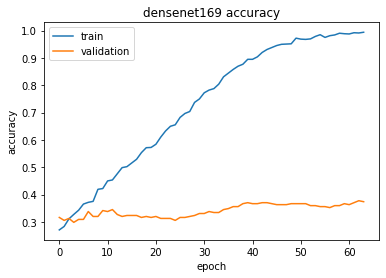

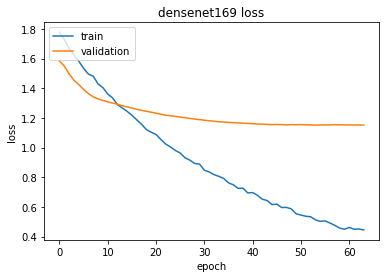

9/9 [==============================] - 3s 73ms/step
[[36 21 31]
 [35 32 40]
 [26 25 32]]
Acuracia balanceada na validacao: 0.3645661661087852


In [ ]:
cria_e_treina_rede('densenet169', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
74842112/74836368 [==============================] - 2s 0us/step
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 18,098,691
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 33s 226ms/step - loss: 1.4738 - acc: 0.3186 - val_loss: 1.2072 - val_acc: 0.2842
Epoch 2/500
70/70 [==============================] - 10s 148ms/step - loss: 1.4255 - acc: 0.3690 - val_loss: 1.1631 - val_acc: 0.3273
Epoch 3/500
70/70 [========================

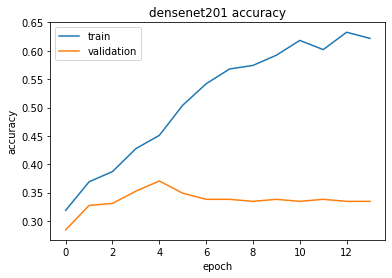

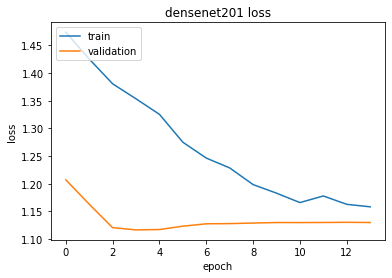

18/18 [==============================] - 3s 41ms/step
[[30 28 30]
 [28 33 46]
 [27 21 35]]
Acuracia balanceada na validacao: 0.3570023509501046


In [ ]:
cria_e_treina_rede('densenet201', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
87916544/87910968 [==============================] - 3s 0us/step
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 15s 115ms/step - loss: 1.4548 - acc: 0.3357 - val_loss: 1.1502 - val_acc: 0.3453
Epoch 2/500
70/70 [==============================] - 6s 81ms/step - loss: 1.4423 - acc: 0.3483 - val_loss: 1.1416 - val_acc: 0.3417
Epoch 3/500
70/70 [===========================

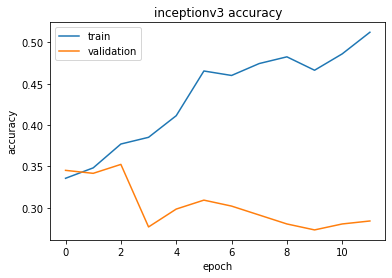

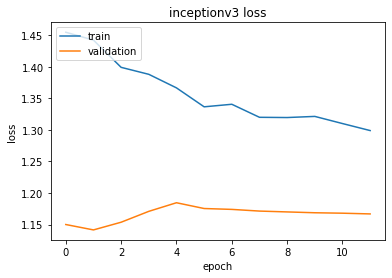

18/18 [==============================] - 2s 34ms/step
[[50 23 15]
 [52 29 26]
 [38 29 16]]
Acuracia balanceada na validacao: 0.3439936466341151


In [ ]:
cria_e_treina_rede('inceptionv3', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
219062272/219055592 [==============================] - 5s 0us/step
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 30s 413ms/step - loss: 1.4513 - acc: 0.2880 - val_loss: 1.3157 - val_acc: 0.3165
Epoch 2/500
35/35 [==============================] - 10s 287ms/step - loss: 1.4298 - acc: 0.3078 - val_loss: 1.2653 - val_acc: 0.2950
Epoch 3/500
35/35 [=======================

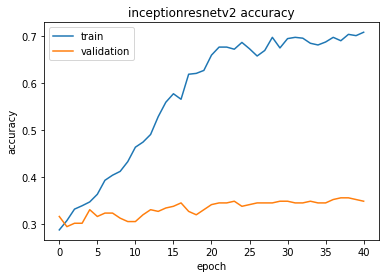

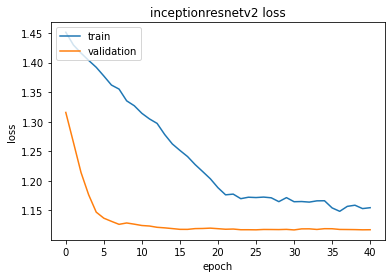

9/9 [==============================] - 3s 81ms/step
[[20 36 32]
 [14 40 53]
 [16 30 37]]
Acuracia balanceada na validacao: 0.34896254516792746


In [ ]:
cria_e_treina_rede('inceptionresnetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
83689472/83683744 [==============================] - 2s 0us/step
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 19s 399ms/step - loss: 1.4211 - acc: 0.3888 - val_loss: 1.1159 - val_acc: 0.3849
Epoch 2/500
35/35 [==============================] - 12s 341ms/step - loss: 1.4126 - acc: 0.4077 - val_loss: 1.1002 - val_acc: 0.4029
Epoch 3/500
35/35 [=========================

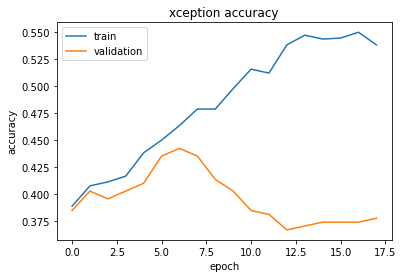

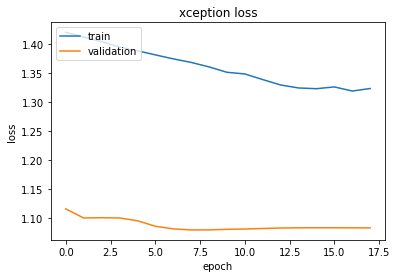

9/9 [==============================] - 1s 60ms/step
[[23 52 13]
 [ 7 85 15]
 [13 57 13]]
Acuracia balanceada na validacao: 0.40412755525073957


In [ ]:
cria_e_treina_rede('xception', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
58892288/58889256 [==============================] - 2s 0us/step
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 11s 118ms/step - loss: 2.5973 - acc: 0.3465 - val_loss: 1.6056 - val_acc: 0.3345
Epoch 2/500
70/70 [==============================] - 6s 91ms/step - loss: 1.7665 - acc: 0.3582 - val_loss: 1.3953 - val_acc: 0.3633
Epoch 3/500
70/70 [==============================] 

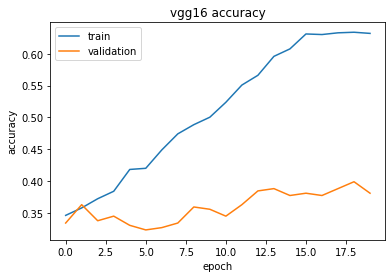

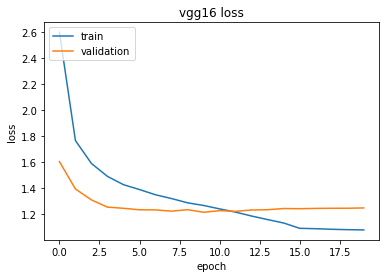

18/18 [==============================] - 1s 36ms/step
[[18 43 27]
 [26 52 29]
 [21 33 29]]
Acuracia balanceada na validacao: 0.34664145110603845


In [ ]:
cria_e_treina_rede('vgg16', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
80142336/80134624 [==============================] - 2s 0us/step
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 11s 110ms/step - loss: 2.9531 - acc: 0.3204 - val_loss: 1.4971 - val_acc: 0.3345
Epoch 2/500
70/70 [==============================] - 8s 107ms/step - loss: 1.7638 - acc: 0.3402 - val_loss: 1.3415 - val_acc: 0.3201
Epoch 3/500
70/70 [==============================]

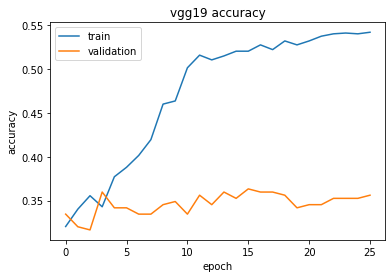

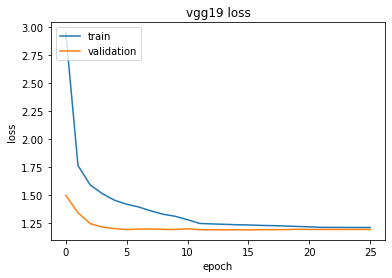

18/18 [==============================] - 1s 37ms/step
[[27 33 28]
 [33 45 29]
 [25 29 29]]
Acuracia balanceada na validacao: 0.358925506614393


In [ ]:
cria_e_treina_rede('vgg19', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)